## Train and Prediction on all data

Using rotated to hz + OpenCv border

Basic default transforms

Progressive image resizing

see https://www.kaggle.com/dipam7/intel-scene-progressive-image-resizing

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join

In [61]:
__version__

'1.0.59.dev0'

In [3]:
#torch.cuda.set_device(2)
#torch.cuda.current_device()

In [4]:
data_dir = Path('data')
colombia_rural = Path('data/stac/colombia/borde_rural')
colombia_soacha = Path('data/stac/colombia/borde_soacha')

In [5]:
guatemala_mixco1 = Path('data/stac/guatemala/mixco_1_and_ebenezer')
guatemala_mixco3 = Path('data/stac/guatemala/mixco_3')

In [6]:
st_lucia_castries = Path('data/stac/st_lucia/castries')
st_lucia_dennery = Path('data/stac/st_lucia/dennery')
st_lucia_gros_islet = Path('data/stac/st_lucia/gros_islet')

In [7]:
COUNTRY='colombia'
REGION='borde_rural'
DATASET = f'{COUNTRY}_{REGION}'
DATASET_PATH=colombia_rural
path=data_dir/f'{COUNTRY}_{REGION}/cropped/'
TRAIN_JSON = f'train-{REGION}.geojson'
TEST_JSON = f'test-{REGION}.geojson'

In [8]:
RETRAIN = True
RESIZE_IMAGES = True

In [9]:
MODEL_NAME='cv_reflect_101'

In [10]:
NB_NUM='03_1'

In [11]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: 876a3c72, DATE: 20191103


In [12]:
#DATE = '20191026'
#UID = '1964891c'

In [13]:
SUB_NUM='12'

In [14]:
img_size=512

In [15]:
train_images=data_dir/f'train/rotated/clipped/reflect/{img_size}'
test_images=data_dir/f'test/rotated/clipped/reflect/{img_size}'

In [16]:
test_names = get_image_files(test_images)

In [17]:
assert len(test_names)==7325

In [18]:
df_all=pd.read_csv(data_dir/'df_train_all.csv')

In [19]:
df_all.tail()

,id,roof_material,verified,country,region
22548,7a22ddec,healthy_metal,False,st_lucia,gros_islet
22549,7a2f73ea,healthy_metal,False,st_lucia,gros_islet
22550,7a34ffa4,healthy_metal,False,st_lucia,gros_islet
22551,7a41560a,healthy_metal,False,st_lucia,gros_islet
22552,7a283ad0,healthy_metal,False,st_lucia,gros_islet


In [20]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [21]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [22]:
assert len(df_test)==7325

In [23]:
df_all.loc[df_all['id'] == '7a204ec4']

,id,roof_material,verified,country,region
12960,7a204ec4,irregular_metal,True,guatemala,mixco_1_and_ebenezer


In [24]:
len(df_all)

22553

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [25]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [26]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_all, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

In [27]:
data_small = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [28]:
data_medium = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

In [29]:
data_large = (src.transform(tfms, size=512)
        .databunch().normalize(imagenet_stats))

In [30]:
#to check what params object has
#dir(data)

In [31]:
data_small.label_list

LabelLists;

Train: LabelList (18043 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/512;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/512;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/reflect/512

`show_batch` still works, and show us the different labels separated by `;`.

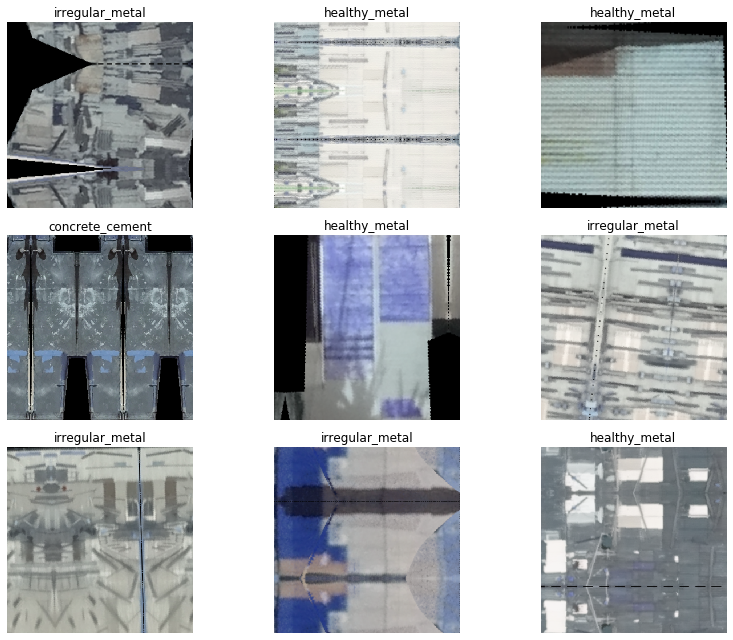

In [32]:
data_small.show_batch(rows=3, figsize=(12,9))

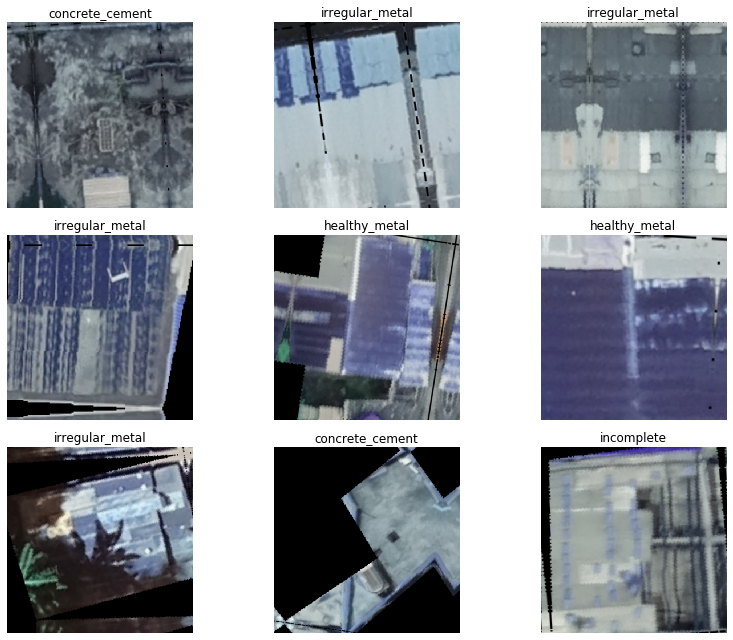

In [33]:
data_large.show_batch(rows=3, figsize=(12,9))

In [34]:
print(data_small.classes)
print(data_large.classes)

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']
['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']


### Model

In [35]:
arch_name = 'rn34'

In [36]:
learn_34 = cnn_learner(data_small, models.resnet34, metrics=[error_rate, accuracy]).to_fp16()

In [37]:
learn_34.model = torch.nn.DataParallel(learn_34.model, device_ids=[0, 1, 2])

We use the LR Finder to pick a good learning rate.

### Train model

In [38]:
learn_34.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


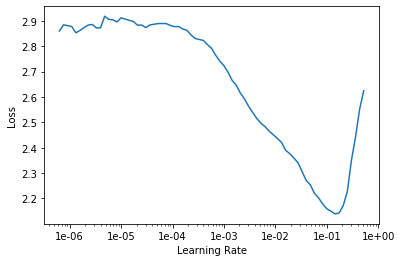

In [39]:
learn_34.recorder.plot()

Then we can fit the head of our network.

In [40]:
lr = 5e-3

In [41]:
learn_34.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.812305,0.629992,0.223947,0.776053,01:34
1,0.589498,0.524384,0.177384,0.822616,01:34
2,0.544131,0.451152,0.163858,0.836142,01:33
3,0.488904,0.408562,0.145455,0.854545,01:35
4,0.449516,0.419346,0.151663,0.848337,01:32


In [43]:
learn_34.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

#### Load model

In [44]:
#learn.load(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

### Re-train

In [45]:
learn_34.data = data_large

In [48]:
learn_34=learn_34.to_fp16()

In [49]:
learn_34.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


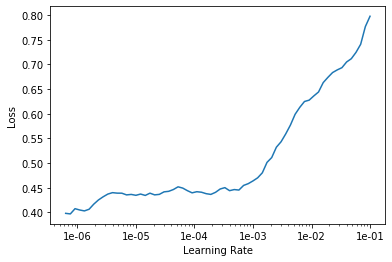

In [50]:
learn_34.lr_find()
learn_34.recorder.plot()

In [51]:
learn_34.fit_one_cycle(5, slice(1e-6, lr/5))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.445358,0.411827,0.149446,0.850554,01:45
1,0.435107,0.394923,0.142350,0.857650,01:46
2,0.409014,0.370342,0.135698,0.864302,01:44
3,0.382192,0.370928,0.139690,0.860310,01:44
4,0.338756,0.365770,0.134590,0.865410,01:44


In [52]:
learn_34.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [53]:
#learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

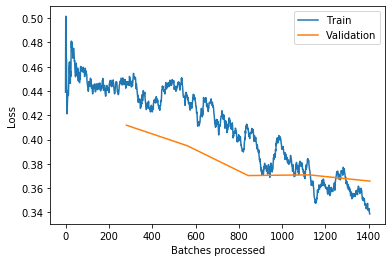

In [54]:
learn_34.recorder.plot_losses()

### ResNet50

In [55]:
learn_34.purge()
learn_34.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [56]:
learn_34 = None

In [57]:
arch_name = 'rn50'

In [58]:
learn_50 = cnn_learner(data_small, models.resnet50, metrics=[error_rate, accuracy]).to_fp16()

In [59]:
learn_50.model = torch.nn.DataParallel(learn_50.model, device_ids=[0, 1, 2])

In [60]:
learn_50.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


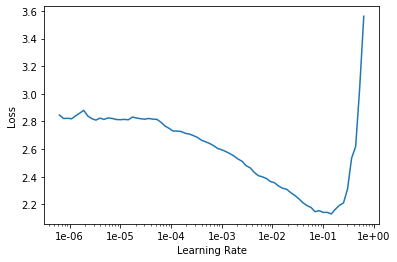

In [61]:
learn_50.recorder.plot()

In [62]:
lr=5e-3

In [63]:
learn_50.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.804959,0.580667,0.196896,0.803104,01:57
1,0.576674,0.481084,0.174723,0.825277,01:55
2,0.476033,0.467472,0.170953,0.829047,01:55
3,0.432817,0.408828,0.146563,0.853437,01:55
4,0.415296,0.390928,0.143681,0.856319,01:55


In [64]:
interp = ClassificationInterpretation.from_learner(learn_50)

losses,idxs = interp.top_losses()

len(data_small.valid_ds)==len(losses)==len(idxs)

True

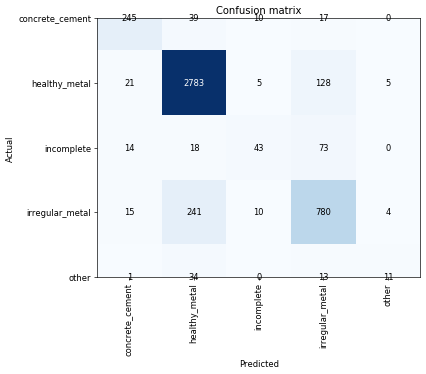

In [65]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=60)

In [67]:
learn_50.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [68]:
learn_50.data = data_large

### Larger size images

In [69]:
learn_50=learn_50.to_fp16()

In [71]:
learn_50.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


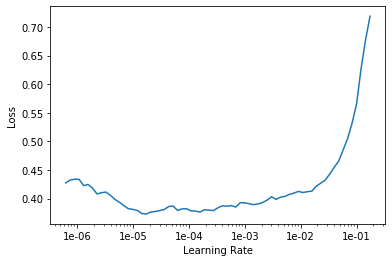

In [72]:
learn_50.lr_find()
learn_50.recorder.plot()

In [73]:
lr=5e-6

In [74]:
learn_50.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.395000,0.391174,0.145676,0.854324,01:54
1,0.394275,0.396397,0.142572,0.857428,01:56
2,0.388263,0.390001,0.140576,0.859424,01:55
3,0.411890,0.392468,0.144568,0.855432,01:56
4,0.404641,0.393093,0.143237,0.856763,01:57


In [75]:
learn_50.save(f'stage-1-large-{arch_name}-{MODEL_NAME}-{DATE}-{UID}')

In [76]:
learn_50.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


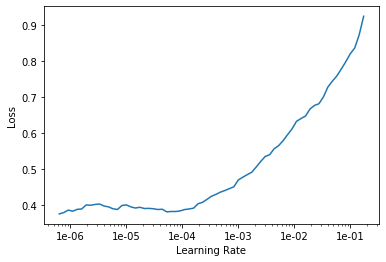

In [77]:
learn_50.lr_find()
learn_50.recorder.plot()

In [78]:
learn_50.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.408336,0.392982,0.145233,0.854767,02:11
1,0.403555,0.391649,0.144346,0.855654,02:13
2,0.391980,0.387267,0.139246,0.860754,02:11
3,0.380890,0.382515,0.138137,0.861863,02:12
4,0.386094,0.380646,0.136142,0.863858,02:11


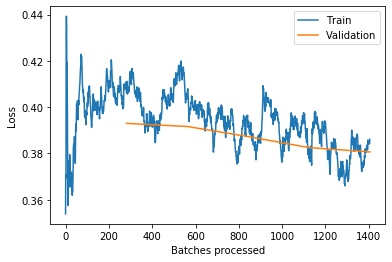

In [79]:
learn_50.recorder.plot_losses()

In [81]:
learn_50.save(f'stage-2-large-{arch_name}-{MODEL_NAME}-{DATE}-{UID}')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

### resnet 101

In [82]:
learn_50.purge()
learn_50.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [83]:
learn_50 = None

In [84]:
gc.collect()

40

In [35]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('df_all', 8195533),
 ('df_test', 1466945),
 ('test_names', 61440),
 ('fastai_types', 2288),
 ('CategoryList', 1472),
 ('DataLoader', 1472),
 ('EmptyLabelList', 1472),
 ('ImageDataBunch', 1472),
 ('ImageList', 1472),
 ('RandTransform', 1472),
 ('FlattenedLoss', 1192),
 ('LabelList', 1192),
 ('Series', 1192),
 ('TfmAffine', 1192),
 ('TfmCoord', 1192),
 ('TfmCrop', 1192),
 ('TfmLighting', 1192),
 ('AUROC', 1064),
 ('AccumulateScheduler', 1064),
 ('AdaptiveConcatPool2d', 1064),
 ('AffineMatrix', 1064),
 ('AverageMetric', 1064),
 ('BatchNorm1dFlat', 1064),
 ('BatchSampler', 1064),
 ('BnFreeze', 1064),
 ('Callback', 1064),
 ('CallbackHandler', 1064),
 ('Category', 1064),
 ('CategoryProcessor', 1064),
 ('ClassificationInterpretation', 1064),
 ('Config', 1064),
 ('ConfusionMatrix', 1064),
 ('Counter', 1064),
 ('DataBunch', 1064),
 ('DataFrame', 1064),
 ('Dataset', 1064),
 ('DatasetType', 1064),
 ('Debugger', 1064),
 ('DeviceDataLoader', 1064),
 ('DistributedDataParallel', 1064),
 ('EmptyLabe

In [36]:
arch_name = 'rn101'

In [37]:
learn_101 = cnn_learner(data_small, models.resnet101, metrics=[error_rate, accuracy]).to_fp16()

In [38]:
learn_101.model = torch.nn.DataParallel(learn_101.model, device_ids=[0, 1, 2])

In [39]:
learn_101.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


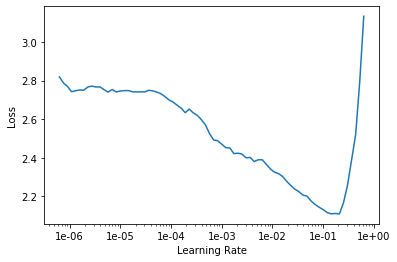

In [40]:
learn_101.recorder.plot()

In [41]:
lr=6e-3

In [42]:
learn_101.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.755425,0.521874,0.182040,0.817960,02:32
1,0.570945,0.462424,0.161197,0.838803,02:34
2,0.484928,0.432089,0.155654,0.844346,02:31
3,0.436069,0.394446,0.146563,0.853437,02:30
4,0.399899,0.371154,0.134590,0.865410,02:31


In [43]:
interp = ClassificationInterpretation.from_learner(learn_101)

losses,idxs = interp.top_losses()

len(data_small.valid_ds)==len(losses)==len(idxs)

True

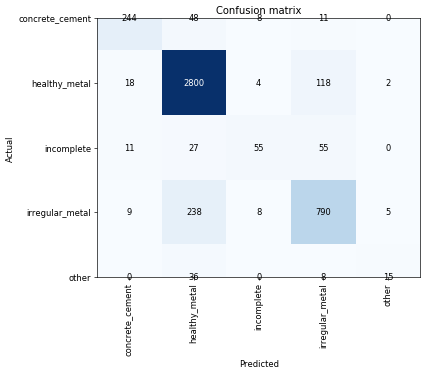

In [44]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=60)

In [46]:
learn_101.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [47]:
learn_101.data = data_large

### Larger size images

In [48]:
learn_101=learn_101.to_fp16()

In [49]:
learn_101.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


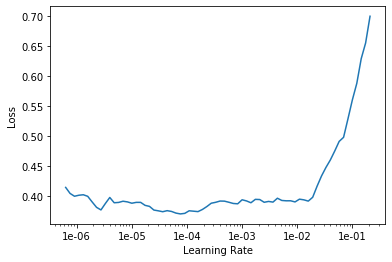

In [50]:
learn_101.lr_find()
learn_101.recorder.plot()

In [51]:
lr=1e-5

In [52]:
learn_101.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.397847,0.365500,0.128381,0.871619,02:29
1,0.386191,0.369524,0.133925,0.866075,02:31
2,0.384045,0.368167,0.129490,0.870510,02:30
3,0.391778,0.368267,0.129712,0.870288,02:30
4,0.374126,0.370747,0.132151,0.867849,02:31


In [53]:
learn_101.save(f'stage-1-large_{arch_name}-{MODEL_NAME}-{DATE}-{UID}')

In [54]:
learn_101.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


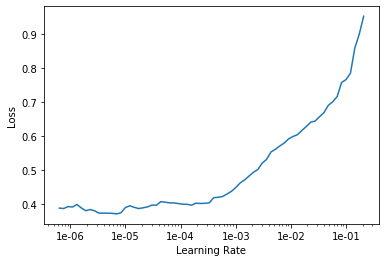

In [55]:
learn_101.lr_find()
learn_101.recorder.plot()

In [56]:
learn_101.fit_one_cycle(5, slice(1e-6, lr/5))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.380446,0.364884,0.132372,0.867628,02:55
1,0.386011,0.364319,0.127938,0.872062,02:57
2,0.384142,0.360594,0.126829,0.873171,02:57
3,0.379906,0.362368,0.129268,0.870732,02:57
4,0.381217,0.367195,0.133703,0.866297,02:55


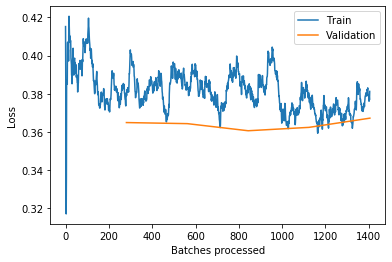

In [57]:
learn_101.recorder.plot_losses()

In [59]:
learn_101.save(f'stage-2-large_{arch_name}-{MODEL_NAME}-{DATE}-{UID}')

In [62]:
interp = ClassificationInterpretation.from_learner(learn_101)

losses,idxs = interp.top_losses()

len(data_small.valid_ds)==len(losses)==len(idxs)

True

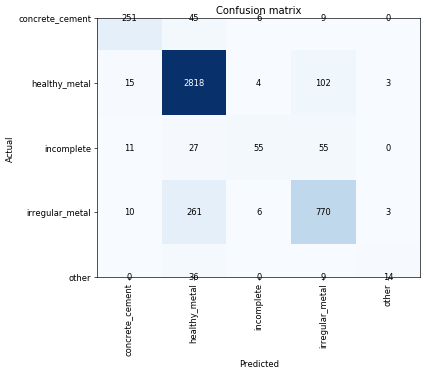

In [63]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=60)

### inference

In [73]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_dataset=ImageList.from_folder(test_images)

In [74]:
len(test_dataset)

7325

In [88]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', test=test_dataset)

In [89]:
#learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', file=f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl', test=test_dataset)

In [94]:
len(learn.dl(DatasetType.Test))

115

Get number of items in the Valid dataset (in DeviceDataLoader)

In [95]:
#assert len(learn.dl(DatasetType.Test).dl)==7325

Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [96]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [97]:
labels = np.argmax(preds, 1)

In [98]:
len(preds)

7325

In [99]:
preds[0].tolist()

[0.03346812352538109,
 0.9584664702415466,
 0.0006572084967046976,
 0.006149182096123695,
 0.001259048469364643]

In [100]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [101]:
len(labels)

7325

In [102]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [103]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [104]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [105]:
test_predictions[0]

'healthy_metal'

In [106]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [107]:
 learn.data.test_ds.x.items

array([PosixPath('data/test/rotated/clipped/256/7a4d9168.tif'),
       PosixPath('data/test/rotated/clipped/256/7a4ae922.tif'),
       PosixPath('data/test/rotated/clipped/256/7a48ca98.tif'),
       PosixPath('data/test/rotated/clipped/256/7a49c614.tif'), ...,
       PosixPath('data/test/rotated/clipped/256/7a486800.tif'),
       PosixPath('data/test/rotated/clipped/256/7a4c49fc.tif'),
       PosixPath('data/test/rotated/clipped/256/7a501f50.tif'),
       PosixPath('data/test/rotated/clipped/256/7a4d27b4.tif')], dtype=object)

In [108]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [109]:
preds_list[0]

[0.03346812352538109,
 0.9584664702415466,
 0.0006572084967046976,
 0.006149182096123695,
 0.001259048469364643]

In [110]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [111]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [112]:
df.head()

,id,pred
0,7a4d9168,"[0.03346812352538109, 0.9584664702415466, 0.00..."
1,7a4ae922,"[0.0044168452732264996, 0.8947269320487976, 0...."
2,7a48ca98,"[0.003338959999382496, 0.23377253115177155, 0...."
3,7a49c614,"[0.0004943751264363527, 0.8595386147499084, 0...."
4,7a4dd4f2,"[0.0005148547934368253, 0.9120095372200012, 0...."


In [113]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [114]:
pred_df.insert(loc=0, column='id', value=ids)

In [115]:
pred_df.columns = cols

In [116]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.033468,0.958466,0.000657,0.006149,0.001259
1,7a4ae922,0.004417,0.894727,0.002138,0.096884,0.001835
2,7a48ca98,0.003339,0.233773,0.013359,0.748489,0.001040
3,7a49c614,0.000494,0.859539,0.000788,0.138634,0.000545
4,7a4dd4f2,0.000515,0.912010,0.000831,0.081663,0.004982


Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [138]:
pred_df = pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

In [139]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.033468,0.958466,0.000657,0.006149,0.001259
1,7a4ae922,0.004417,0.894727,0.002138,0.096884,0.001835
2,7a48ca98,0.003339,0.233773,0.013359,0.748489,0.001040
3,7a49c614,0.000494,0.859539,0.000788,0.138634,0.000545
4,7a4dd4f2,0.000515,0.912010,0.000831,0.081663,0.004982


In [149]:
pred_ids=pred_df['id'].values.tolist()

In [119]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

In [129]:
df_baseline.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d630a,0.093275,0.496369,0.044923,0.352455,0.012979
1,7a4bbbd6,0.093275,0.496369,0.044923,0.352455,0.012979
2,7a4ac744,0.093275,0.496369,0.044923,0.352455,0.012979
3,7a4881fa,0.093275,0.496369,0.044923,0.352455,0.012979
4,7a4aa4a8,0.093275,0.496369,0.044923,0.352455,0.012979


In [146]:
baseline_ids=df_baseline['id'].values.tolist()

In [147]:
baseline_ids

['7a4d630a',
 '7a4bbbd6',
 '7a4ac744',
 '7a4881fa',
 '7a4aa4a8',
 '7a514434',
 '7a485f72',
 '7a4b8d32',
 '7a47eb3c',
 '7a4be3ae',
 '7a46a330',
 '7a481620',
 '7a49c678',
 '7a4ea044',
 '7a47aa1e',
 '7a51aa1e',
 '7a498be0',
 '7a4a2848',
 '7a4c4cd6',
 '7a465038',
 '7a4e94aa',
 '7a49f62a',
 '7a45b6f0',
 '7a50bb90',
 '7a4d38e4',
 '7a48a3a6',
 '7a4ebe9e',
 '7a48352e',
 '7a4bfaec',
 '7a51e060',
 '7a4c0f5a',
 '7a4b9976',
 '7a4b27d4',
 '7a51c698',
 '7a474bb4',
 '7a480054',
 '7a4a4044',
 '7a4c35ca',
 '7a4d3fd8',
 '7a4c1a68',
 '7a4eb1c4',
 '7a4a51ce',
 '7a4a14fc',
 '7a5015d2',
 '7a4ba95c',
 '7a5101ae',
 '7a4d0a22',
 '7a5134ee',
 '7a4a85c2',
 '7a514b14',
 '7a4d0a90',
 '7a485fd6',
 '7a4f668c',
 '7a44e752',
 '7a5162d4',
 '7a465894',
 '7a4c9a10',
 '7a485810',
 '7a4a9788',
 '7a503198',
 '7a4e206a',
 '7a4c15ea',
 '7a4f8536',
 '7a513df4',
 '7a4d7624',
 '7a4c9e8e',
 '7a4b2554',
 '7a502b12',
 '7a4c32e6',
 '7a4a8a2c',
 '7a467b76',
 '7a51b554',
 '7a4622e8',
 '7a4a599e',
 '7a4d17c4',
 '7a4fb740',
 '7a4ceed4',

In [150]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [151]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [152]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
0,7a4d9168,0.033468,0.958466,0.000657,0.006149,0.001259,7a4d9168
1,7a4ae922,0.004417,0.894727,0.002138,0.096884,0.001835,7a4ae922
2,7a48ca98,0.003339,0.233773,0.013359,0.748489,0.001040,7a48ca98
3,7a49c614,0.000494,0.859539,0.000788,0.138634,0.000545,7a49c614
4,7a4dd4f2,0.000515,0.912010,0.000831,0.081663,0.004982,7a4dd4f2


In [153]:
pred_df=pred_df.sort_values('id_cat')

In [154]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
716,7a4d630a,0.013808,0.980777,0.000303,0.003716,0.001395,7a4d630a
764,7a4bbbd6,0.000810,0.949852,0.000470,0.048376,0.000491,7a4bbbd6
1841,7a4ac744,0.001608,0.855418,0.001628,0.140389,0.000957,7a4ac744
3363,7a4881fa,0.004803,0.234743,0.006764,0.752769,0.000920,7a4881fa
133,7a4aa4a8,0.004477,0.706235,0.003069,0.283955,0.002263,7a4aa4a8


In [156]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [157]:
pred_df.to_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

In [1]:
### Submission 2: 0.4461


In [16]:
arch_name = 'rn50'
pred_df=pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

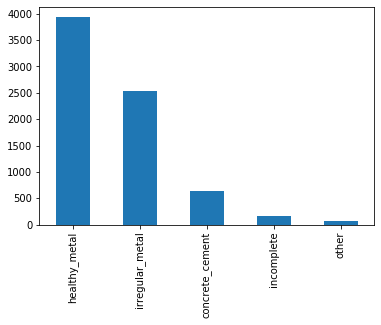

In [17]:
pred_df.drop(columns=['id'],inplace=True)
classes=pred_df.idxmax(axis=1)
pd.value_counts(classes).plot(kind="bar")